In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import joblib
import pickle

In [3]:
data = pd.read_csv(r'drug200.csv')
data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [4]:
data.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
data.Drug.value_counts()

Drug
drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

In [7]:
data.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [8]:
data.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [9]:
# sweetviz
##########

# pip install sweetviz
import sweetviz
report = sweetviz.analyze([data,'data'])
report.show_html('report.html')

                                             |                                             | [  0%]   00:00 ->…

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [10]:
X = data.iloc[:,0:5]
y = data['Drug']

In [11]:
y

0      drugY
1      drugC
2      drugC
3      drugX
4      drugY
       ...  
195    drugC
196    drugC
197    drugX
198    drugX
199    drugX
Name: Drug, Length: 200, dtype: object

In [12]:
numeric_feature = X.select_dtypes(exclude =['object']).columns
numeric_feature

Index(['Age', 'Na_to_K'], dtype='object')

In [13]:
categ_feature = X.select_dtypes(include = ['object']).columns
categ_feature

Index(['Sex', 'BP', 'Cholesterol'], dtype='object')

In [14]:
num_pipeline = Pipeline(steps = [('mode',SimpleImputer(strategy = 'mean'))])
num_pipeline

Pipeline(steps=[('mode', SimpleImputer())])

In [15]:
categ_pipeline = Pipeline(steps = [('mode', SimpleImputer(strategy = 'most_frequent'))])
categ_pipeline

Pipeline(steps=[('mode', SimpleImputer(strategy='most_frequent'))])

In [16]:
preprocess = ColumnTransformer(transformers = [('num', num_pipeline, numeric_feature)])

In [17]:
preprocess1 = ColumnTransformer(transformers = [('categ', categ_pipeline, categ_feature)])

In [18]:
impute_data = preprocess.fit(X)
impute_data1 = preprocess1.fit(X)

In [19]:
joblib.dump(impute_data, 'num')
joblib.dump(impute_data1, 'categ')

['categ']

In [20]:
num_data = pd.DataFrame(impute_data.transform(X), columns = numeric_feature)
categ_data = pd.DataFrame(impute_data1.transform(X), columns = categ_feature)
categ_data

,Sex,BP,Cholesterol
0,F,HIGH,HIGH
1,M,LOW,HIGH
2,M,LOW,HIGH
3,F,NORMAL,HIGH
4,F,LOW,HIGH
...,...,...,...
195,F,LOW,HIGH
196,M,LOW,HIGH
197,M,NORMAL,HIGH
198,M,NORMAL,NORMAL


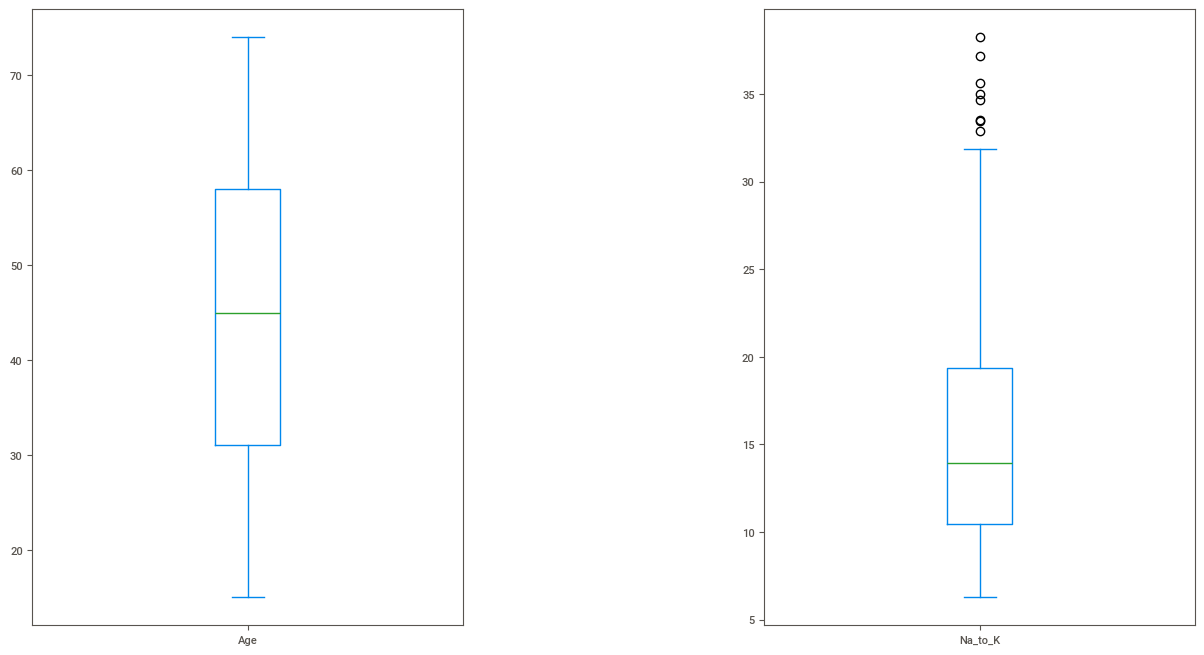

In [21]:
X.plot(kind = 'box', sharey = False, subplots = True, figsize = (15,8))
plt.subplots_adjust(wspace = 0.7)
plt.show()

In [22]:
winsor = Winsorizer(capping_method = 'iqr',
                   tail = 'both',
                   fold = 1.5,
                   variables = list(num_data.columns))
winsor

Winsorizer(capping_method='iqr', fold=1.5, tail='both',
           variables=['Age', 'Na_to_K'])

In [23]:
clean = winsor.fit(num_data)

In [24]:
joblib.dump(clean, 'winsor')

['winsor']

In [25]:
num_data1 = clean.transform(num_data)

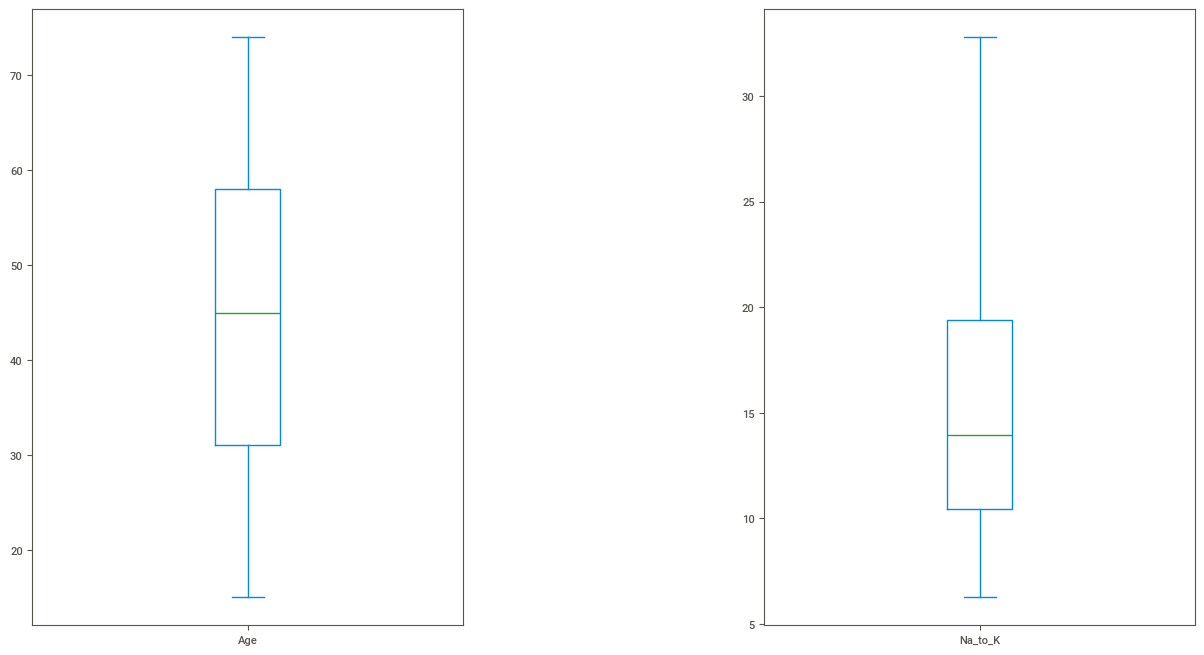

In [26]:
num_data1.plot(kind = 'box', sharey = False, subplots = True, figsize = (15,8))
plt.subplots_adjust(wspace = 0.7)
plt.show()

In [27]:
scale_pipeline = Pipeline(steps = [('scale', MinMaxScaler())])

In [28]:
scale_columntransformer = ColumnTransformer([('scale', scale_pipeline, numeric_feature)])

In [29]:
scale = scale_columntransformer.fit(num_data1)

In [30]:
joblib.dump(scale, 'scale')

['scale']

In [31]:
scaled_data = pd.DataFrame(scale.transform(num_data1))
scaled_data

,0,1
0,0.135593,0.719880
1,0.542373,0.257386
2,0.542373,0.145025
3,0.220339,0.057670
4,0.779661,0.444088
...,...,...
195,0.694915,0.199828
196,0.016949,0.216386
197,0.627119,0.136727
198,0.135593,0.292350


In [32]:
encoding_pipeline = Pipeline([('onehot', OneHotEncoder())])

In [33]:
preprocess_pipeline = ColumnTransformer([('categorical', encoding_pipeline, categ_feature)])

In [34]:
clean = preprocess_pipeline.fit(categ_data)

In [35]:
# Save the Encoding model
joblib.dump(clean,'encoding')

['encoding']

In [36]:
encode_data = pd.DataFrame(clean.transform(categ_data))

In [37]:
# To get feature names for Categorical columns after Onehotencoding 
encode_data.columns = clean.get_feature_names_out(input_features = categ_data.columns)
encode_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   categorical__Sex_F               200 non-null    float64
 1   categorical__Sex_M               200 non-null    float64
 2   categorical__BP_HIGH             200 non-null    float64
 3   categorical__BP_LOW              200 non-null    float64
 4   categorical__BP_NORMAL           200 non-null    float64
 5   categorical__Cholesterol_HIGH    200 non-null    float64
 6   categorical__Cholesterol_NORMAL  200 non-null    float64
dtypes: float64(7)
memory usage: 11.1 KB


In [38]:
encode_data

,categorical__Sex_F,categorical__Sex_M,categorical__BP_HIGH,categorical__BP_LOW,categorical__BP_NORMAL,categorical__Cholesterol_HIGH,categorical__Cholesterol_NORMAL
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
195,1.0,0.0,0.0,1.0,0.0,1.0,0.0
196,0.0,1.0,0.0,1.0,0.0,1.0,0.0
197,0.0,1.0,0.0,0.0,1.0,1.0,0.0
198,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [39]:
clean_data = pd.concat([scaled_data, encode_data], axis = 1, ignore_index = True)

In [40]:
clean_data

,0,1,2,3,4,5,6,7,8
0,0.135593,0.719880,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.542373,0.257386,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.542373,0.145025,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.220339,0.057670,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.779661,0.444088,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
195,0.694915,0.199828,1.0,0.0,0.0,1.0,0.0,1.0,0.0
196,0.016949,0.216386,0.0,1.0,0.0,1.0,0.0,1.0,0.0
197,0.627119,0.136727,0.0,1.0,0.0,0.0,1.0,1.0,0.0
198,0.135593,0.292350,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(clean_data, y, test_size = 0.2, stratify = y, random_state = 0 )

In [42]:
# Proportion of Target variable categories are consistent across train and test

print(Y_train.value_counts()/ 180)
print('\n')
print(Y_test.value_counts()/20)

Drug
drugY    0.405556
drugX    0.238889
drugA    0.100000
drugC    0.072222
drugB    0.072222
Name: count, dtype: float64


Drug
drugY    0.90
drugX    0.55
drugA    0.25
drugC    0.15
drugB    0.15
Name: count, dtype: float64


In [43]:
#Decision Tree Model

model = DT(criterion = 'entropy')
model.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy')

In [44]:
preds = model.predict(X_test)
preds

array(['drugX', 'drugC', 'drugX', 'drugY', 'drugB', 'drugY', 'drugX',
       'drugX', 'drugY', 'drugY', 'drugX', 'drugA', 'drugY', 'drugA',
       'drugY', 'drugA', 'drugY', 'drugX', 'drugY', 'drugA', 'drugY',
       'drugX', 'drugY', 'drugY', 'drugY', 'drugC', 'drugB', 'drugY',
       'drugY', 'drugY', 'drugX', 'drugX', 'drugC', 'drugY', 'drugX',
       'drugY', 'drugB', 'drugA', 'drugY', 'drugX'], dtype=object)

In [61]:
#print(accuracy_score(Y_test, preds))
print(accuracy_score(Y_test, preds))

1.0


In [46]:
pd.crosstab(Y_test, preds, rownames = ['Actual'], colnames = ['Prediction'])

Prediction,drugA,drugB,drugC,drugX,drugY
Actual,,,,,
drugA,5,0,0,0,0
drugB,0,3,0,0,0
drugC,0,0,3,0,0
drugX,0,0,0,11,0
drugY,0,0,0,0,18


In [47]:
#Hyperparameter Optimization
# create a dictionary of all hyperparameters to be experimented
param_grid = {'criterion' :['gini','entropy'], 'max_depth' : np.arange(3, 15)}

# Decision tree model
dtree_model = DT()

dtree_gscv = GridSearchCV(dtree_model, param_grid, cv = 5, scoring = 'accuracy', return_train_score = False, verbose = 1)

In [48]:
# Train
dtree_gscv.fit(clean_data, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             scoring='accuracy', verbose=1)

In [49]:
# The best set of parameter values
dtree_gscv.best_params_

{'criterion': 'gini', 'max_depth': 4}

In [50]:
# Model with best parameter values
DT_best = dtree_gscv.best_estimator_
DT_best

DecisionTreeClassifier(max_depth=4)

In [51]:
preds1 = DT_best.predict(X_test)
preds1

array(['drugX', 'drugC', 'drugX', 'drugY', 'drugB', 'drugY', 'drugX',
       'drugX', 'drugY', 'drugY', 'drugX', 'drugA', 'drugY', 'drugA',
       'drugY', 'drugA', 'drugY', 'drugX', 'drugY', 'drugA', 'drugY',
       'drugX', 'drugY', 'drugY', 'drugY', 'drugC', 'drugB', 'drugY',
       'drugY', 'drugY', 'drugX', 'drugX', 'drugC', 'drugY', 'drugX',
       'drugY', 'drugB', 'drugA', 'drugY', 'drugX'], dtype=object)

In [52]:
pd.crosstab(Y_test, preds, rownames = ['Actual'], colnames= ['Predictions']) 

Predictions,drugA,drugB,drugC,drugX,drugY
Actual,,,,,
drugA,5,0,0,0,0
drugB,0,3,0,0,0
drugC,0,0,3,0,0
drugX,0,0,0,11,0
drugY,0,0,0,0,18


In [53]:
# Accuracy

print(accuracy_score(Y_test, preds))


1.0


In [54]:
pickle.dump(DT_best, open('DT.pkl', 'wb'))

In [55]:
#Model Training with Cross Validation

from sklearn.model_selection import cross_validate


def cross_validation(model, _X, _y, _cv=5):
    
    '''Function to perform 5 Folds Cross-Validation
    Parameters
    ----------
    model: Python Class, default=None
          This is the machine learning algorithm to be used for training.
    _X: array
       This is the matrix of features.
    _y: array
       This is the target variable.
    _cv: int, default=5
      Determines the number of folds for cross-validation.
    Returns
    -------
    The function returns a dictionary containing the metrics 'accuracy', 'precision',
    'recall', 'f1' for both training set and validation set.
    '''
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                           X=_X,
                           y=_y,
                           cv=_cv,
                           scoring=_scoring,
                           return_train_score=True)

    return pd.DataFrame({"Training Accuracy scores": results['train_accuracy'],
          "Mean Training Accuracy": results['train_accuracy'].mean()*100,
          "Training Precision scores": results['train_precision'],
          "Mean Training Precision": results['train_precision'].mean(),
          "Training Recall scores": results['train_recall'],
          "Mean Training Recall": results['train_recall'].mean(),
          "Training F1 scores": results['train_f1'],
          "Mean Training F1 Score": results['train_f1'].mean(),
          "Validation Accuracy scores": results['test_accuracy'],
          "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
          "Validation Precision scores": results['test_precision'],
          "Mean Validation Precision": results['test_precision'].mean(),
          "Validation Recall scores": results['test_recall'],
          "Mean Validation Recall": results['test_recall'].mean(),
          "Validation F1 scores": results['test_f1'],
          "Mean Validation F1 Score": results['test_f1'].mean()
          })

In [65]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(Y_train)

label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))

print("Mapping of Label Encoded Classes", label_encoder_name_mapping, sep="\n")
print("Label Encoded Target Variable", encoded_y, sep="\n")


Mapping of Label Encoded Classes
{'drugA': 0, 'drugB': 1, 'drugC': 2, 'drugX': 3, 'drugY': 4}
Label Encoded Target Variable
[4 3 3 3 0 4 4 3 3 2 3 4 4 4 4 4 4 3 2 4 3 0 4 3 4 4 4 3 3 1 3 4 0 4 1 3 3
 0 3 4 4 4 4 3 3 0 3 0 3 1 4 1 4 4 4 4 4 4 3 4 3 4 2 0 3 4 3 1 1 4 4 3 4 4
 4 3 4 4 1 4 4 4 3 4 0 4 4 3 0 1 4 4 1 4 4 1 3 4 2 4 4 3 0 4 0 3 3 4 3 4 3
 0 2 4 0 2 4 4 2 4 4 3 3 4 3 3 4 0 0 2 4 4 3 4 2 3 2 4 4 1 3 3 1 0 4 4 4 4
 0 2 2 2 0 3 1 4 3 4 4 4]


In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

decision_tree_result = cross_validate(DT_best, X_train, encoded_y, cv=5, scoring=scoring)


In [75]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Define custom scoring function with specified average parameter
def cross_validation(model, X, y, cv):
    scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='mean'),
               'recall': make_scorer(recall_score, average='mean'),       
               'f1': make_scorer(f1_score, average='mean')}                
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return scores


In [76]:
decision_tree_result

{'fit_time': array([0.00299835, 0.00300121, 0.00273991, 0.00203204, 0.00199962]),
 'score_time': array([1.62850499, 0.00561714, 0.0060389 , 0.00690842, 0.00800276]),
 'test_accuracy': array([0.96875, 1.     , 0.96875, 1.     , 0.96875]),
 'test_precision': array([0.97070312, 1.        , 0.9765625 , 1.        , 0.9765625 ]),
 'test_recall': array([0.96875, 1.     , 0.96875, 1.     , 0.96875]),
 'test_f1': array([0.96833491, 1.        , 0.96875   , 1.        , 0.96785714])}

In [77]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

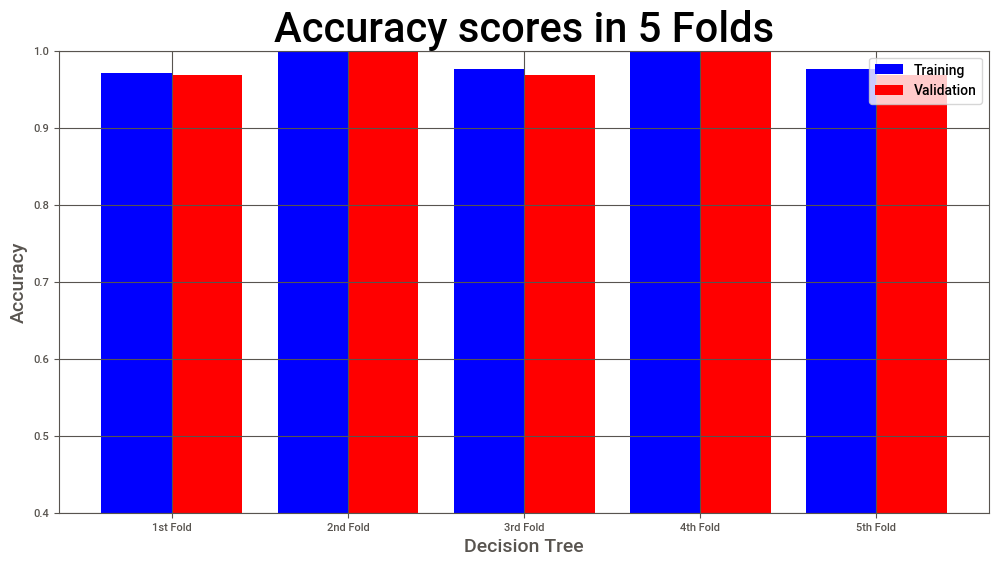

In [84]:
model_name = "Decision Tree"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            decision_tree_result["test_precision"],
            decision_tree_result["test_accuracy"])


In [81]:
print(decision_tree_result.keys())


dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1'])
